--- 1. Persiapan Dataset ---
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
--- 2.1. Membangun VAE Encoder ---
--- 2.2. Membangun VAE Decoder ---
--- 2.3. Membangun Model VAE Lengkap ---
--- 3. Kompilasi dan Pelatihan VAE ---
Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - loss: 59.3350 - val_loss: 49.2914
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 40ms/step - loss: 48.8082 - val_loss: 48.1503
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 47.8598 - val_loss: 47.6632
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 43ms/step - loss: 47.5697 - val_loss: 47.3438
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - loss: 47.1662 - val_loss: 47.2420
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 46.9819 - val_loss: 47.0664
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - loss: 46.8347 - val_loss: 46.8611
Epo

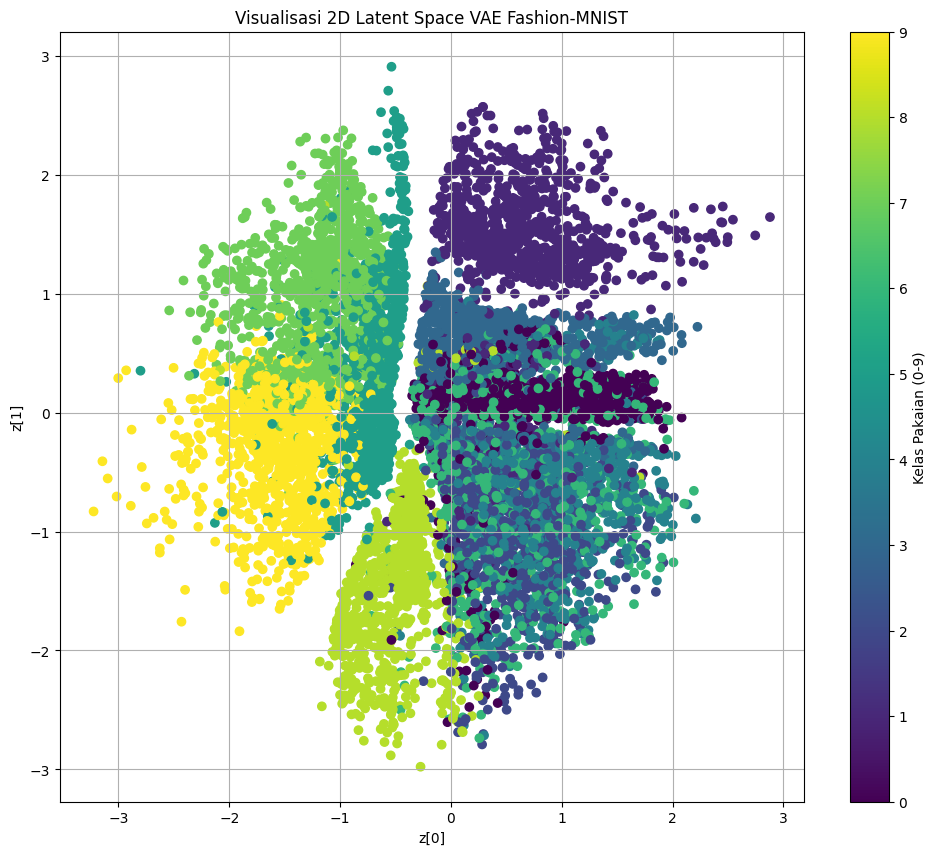

Visualisasi 2D Latent Space VAE selesai. Titik-titik yang berkelompok menunjukkan representasi yang baik.

--- 6. Latent Space Arithmetic (Penjumlahan dan Pengurangan) ---
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


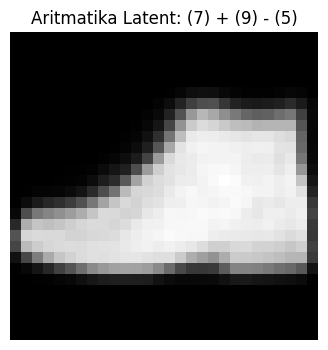

Hasil rekonstruksi dari aritmatika latent space: 7 + 9 - 5

--- 7.1. Membangun Autoencoder Biasa untuk Perbandingan ---
--- 7.2. Visualisasi Perbandingan Rekonstruksi ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


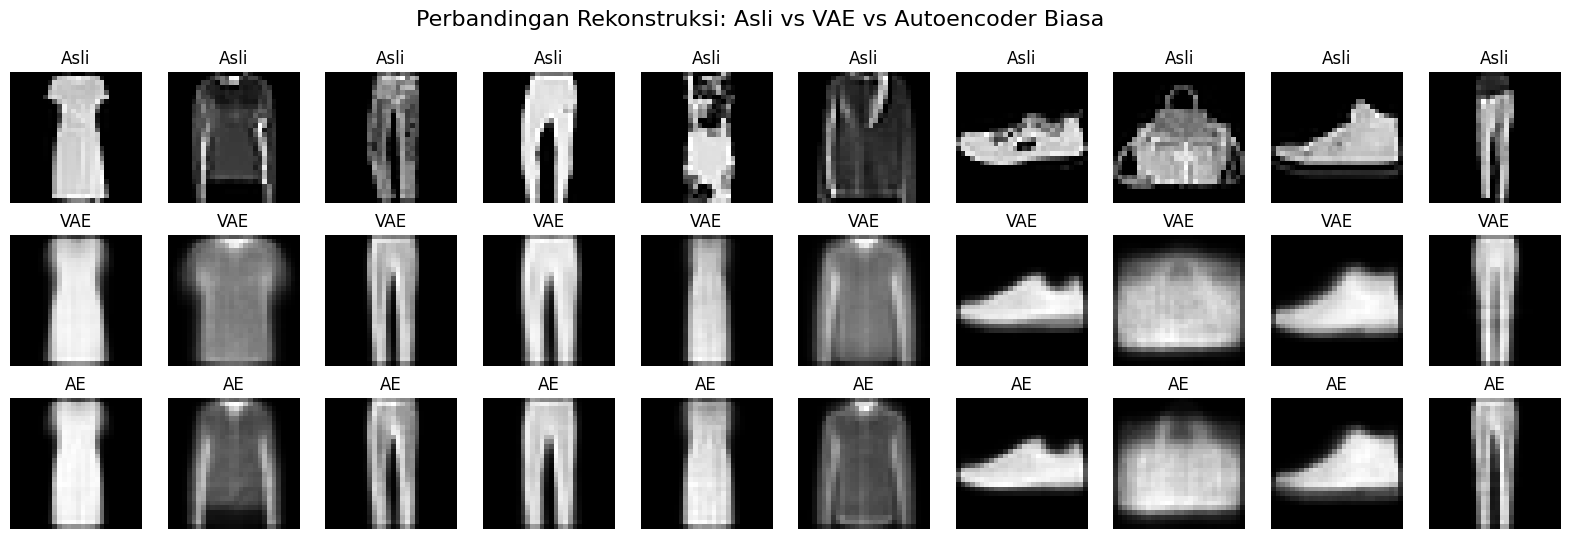

Visualisasi perbandingan rekonstruksi selesai. Perhatikan bagaimana VAE cenderung menghasilkan citra yang sedikit lebih 'buram' atau 'halus' (smooth) karena sifat probabilistiknya, sementara AE mungkin lebih tajam tetapi kurang mampu melakukan interpolasi antar titik laten.


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Lambda
from tensorflow.keras.models import Model # Keep Model for Functional API for encoder/decoder
from tensorflow.keras.losses import binary_crossentropy
import keras.ops as ops # Import keras.ops
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.decomposition import PCA

# --- 1. Persiapan Dataset Fashion-MNIST ---
print("--- 1. Persiapan Dataset ---")
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalisasi dan Reshape untuk VAE/AE
# Ubah citra dari (60000, 28, 28) menjadi (60000, 784)
# Normalisasi ke rentang [0, 1]
image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
input_shape = (original_dim,)
batch_size = 128
latent_dim = 2 # Dimensi laten 2 agar mudah divisualisasikan
epochs = 50

# --- 2. Variational Autoencoder (VAE) ---

# Fungsi Sampling (Reparameterization Trick)
def sampling(args):
    """Menggunakan trik reparameterisasi untuk mengambil sampel dari z."""
    z_mean, z_log_var = args
    # Use keras.ops for tensor operations
    epsilon = tf.random.normal(ops.shape(z_mean)) # Corrected: ops.random.normal -> tf.random.normal
    return z_mean + ops.exp(0.5 * z_log_var) * epsilon

# --- 2.1. Encoder VAE ---
print("--- 2.1. Membangun VAE Encoder ---")
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(512, activation='relu')(inputs)
x = Dense(256, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# z adalah output dari trik reparameterisasi
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
vae_encoder = Model(inputs, [z_mean, z_log_var, z], name='vae_encoder')
# vae_encoder.summary()

# --- 2.2. Decoder VAE ---
print("--- 2.2. Membangun VAE Decoder ---")
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(256, activation='relu')(latent_inputs)
x = Dense(512, activation='relu')(x)
outputs = Dense(original_dim, activation='sigmoid')(x)
vae_decoder = Model(latent_inputs, outputs, name='vae_decoder')
# vae_decoder.summary()

# --- 2.3. Model VAE Lengkap ---
print("--- 2.3. Membangun Model VAE Lengkap ---")

# Define VAE as a custom Model subclass to handle the custom loss
class VAE(Model):
    def __init__(self, encoder, decoder, original_dim, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.original_dim = original_dim

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)

        # Calculate reconstruction loss (sum per sample)
        # Use BinaryCrossentropy class with reduction=NONE to get per-element loss,
        # then sum over the feature dimension.
        bce_loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.NONE)
        reconstruction_loss = bce_loss_obj(inputs, reconstruction) # shape (batch_size, original_dim)
        reconstruction_loss = ops.sum(reconstruction_loss, axis=-1) # sum over features, shape (batch_size,)

        # KL Divergence Loss already has shape (batch_size,)
        kl_loss = 1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var)
        kl_loss = ops.sum(kl_loss, axis=-1)
        kl_loss *= -0.5

        # Total VAE Loss (per sample)
        total_vae_loss_per_sample = reconstruction_loss + kl_loss

        # Add the mean of this total loss to the model's losses.
        # This loss will be minimized during `fit`.
        self.add_loss(ops.mean(total_vae_loss_per_sample))

        return reconstruction

# Instantiate the custom VAE model
vae = VAE(vae_encoder, vae_decoder, original_dim, name='vae_mlp')

# --- 3. Kompilasi dan Pelatihan VAE ---
print("--- 3. Kompilasi dan Pelatihan VAE ---")
# The loss is handled internally by VAE's add_loss, so no external loss is needed here.
vae.compile(optimizer='adam')
history = vae.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))


# --- 4. Variational Autoencoder (VAE) Sederhana untuk Fashion-MNIST ---
# Ini telah dilakukan pada langkah 2 dan 3.


# --- 5. Visualisasi Distribusi Latent Space VAE ---
print("\n--- 5. Visualisasi Distribusi Latent Space VAE ---")
# Encode citra uji menjadi latent space
z_mean_pred, _, _ = vae_encoder.predict(x_test, batch_size=batch_size)

plt.figure(figsize=(12, 10))
# Scatter plot z_mean dari data uji
scatter = plt.scatter(z_mean_pred[:, 0], z_mean_pred[:, 1], c=y_test, cmap='viridis')
plt.colorbar(scatter, ticks=range(10), label='Kelas Pakaian (0-9)')
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.title("Visualisasi 2D Latent Space VAE Fashion-MNIST")
plt.grid()
plt.show()
print("Visualisasi 2D Latent Space VAE selesai. Titik-titik yang berkelompok menunjukkan representasi yang baik.")

# --- 6. Latent Space Arithmetic (Contoh pada Fashion-MNIST) ---
print("\n--- 6. Latent Space Arithmetic (Penjumlahan dan Pengurangan) ---")

# Kelas-kelas yang ingin diuji:
# 0: T-shirt/top, 1: Trouser, 2: Pullover, 3: Dress, 4: Coat, 5: Sandal, 6: Shirt, 7: Sneaker, 8: Bag, 9: Ankle boot
class_a = 7 # Sneaker
class_b = 9 # Ankle boot
class_c = 5 # Sandal

def get_mean_latent(vae_encoder, x_data, y_data, target_class):
    """Menghitung rata-rata z_mean untuk kelas tertentu."""
    x_class = x_data[y_data == target_class]
    z_mean_class, _, _ = vae_encoder.predict(x_class)
    return np.mean(z_mean_class, axis=0)

# Menghitung rata-rata latent vector
mean_a = get_mean_latent(vae_encoder, x_test, y_test, class_a) # Sneaker
mean_b = get_mean_latent(vae_encoder, x_test, y_test, class_b) # Ankle boot
mean_c = get_mean_latent(vae_encoder, x_test, y_test, class_c) # Sandal

# Aritmatika: Sneaker - Sandal + Ankle boot
# Tujuan: Menghasilkan citra yang menggabungkan fitur A dan B, menghilangkan fitur C
# Latent Vector Hasil = mean_a - mean_c + mean_b
# Contoh sederhana: Sandal + (Ankle boot - Sandal) -> Harusnya mirip Ankle boot
# Contoh ini lebih ke interpolasi sederhana
latent_result = mean_a + (mean_b - mean_c)

# Decode hasil aritmatika
decoded_img = vae_decoder.predict(np.array([latent_result]))
decoded_img = decoded_img.reshape(image_size, image_size)

# Visualisasi hasil aritmatika
plt.figure(figsize=(4, 4))
plt.imshow(decoded_img, cmap='gray')
plt.title(f"Aritmatika Latent: ({class_a}) + ({class_b}) - ({class_c})")
plt.axis('off')
plt.show()
print(f"Hasil rekonstruksi dari aritmatika latent space: {class_a} + {class_b} - {class_c}")


# --- 7. Perbandingan Rekonstruksi antara VAE dan Autoencoder Biasa ---

# --- 7.1. Membangun Autoencoder (AE) Biasa ---
print("\n--- 7.1. Membangun Autoencoder Biasa untuk Perbandingan ---")
# Encoder AE
ae_input = Input(shape=input_shape, name='ae_encoder_input')
h_ae = Dense(512, activation='relu')(ae_input)
h_ae = Dense(256, activation='relu')(h_ae)
latent_ae = Dense(latent_dim, name='ae_latent')(h_ae)
ae_encoder = Model(ae_input, latent_ae, name='ae_encoder')

# Decoder AE (Menggunakan arsitektur yang sama dengan decoder VAE)
h_decode_ae = Dense(256, activation='relu')(latent_ae)
h_decode_ae = Dense(512, activation='relu')(h_decode_ae)
ae_output = Dense(original_dim, activation='sigmoid')(h_decode_ae)
ae = Model(ae_input, ae_output, name='autoencoder')

# Kompilasi dan Pelatihan AE
ae.compile(optimizer='adam', loss='binary_crossentropy')
ae.fit(x_train, x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, x_test), verbose=0)


# --- 7.2. Visualisasi Perbandingan Rekonstruksi ---
print("--- 7.2. Visualisasi Perbandingan Rekonstruksi ---")

# Pilih 10 citra uji secara acak
n = 10
indices = np.random.choice(len(x_test), n, replace=False)
x_test_subset = x_test[indices]

# Rekonstruksi oleh VAE
vae_reconstructions = vae.predict(x_test_subset)

# Rekonstruksi oleh AE
ae_reconstructions = ae.predict(x_test_subset)

# Plot perbandingan
plt.figure(figsize=(20, 6))
for i in range(n):
    # Citra Asli
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_subset[i].reshape(image_size, image_size), cmap='gray')
    ax.set_title("Asli")
    plt.axis("off")

    # Rekonstruksi VAE
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(vae_reconstructions[i].reshape(image_size, image_size), cmap='gray')
    ax.set_title("VAE")
    plt.axis("off")

    # Rekonstruksi AE
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(ae_reconstructions[i].reshape(image_size, image_size), cmap='gray')
    ax.set_title("AE")
    plt.axis("off")

plt.suptitle("Perbandingan Rekonstruksi: Asli vs VAE vs Autoencoder Biasa", fontsize=16)
plt.show()
print("Visualisasi perbandingan rekonstruksi selesai. Perhatikan bagaimana VAE cenderung menghasilkan citra yang sedikit lebih 'buram' atau 'halus' (smooth) karena sifat probabilistiknya, sementara AE mungkin lebih tajam tetapi kurang mampu melakukan interpolasi antar titik laten.")